In [1]:
import os 
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter, FuncFormatter
import dataframe_image as dfi # for saving styled data frame print-out table as png

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 3)

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [2]:
# set paths and create dirs 
base_dir = '../..'
data_dir = os.path.join(base_dir, 'data')
helper_dir = os.path.join(base_dir, 'helper')
output_dir = os.path.join(base_dir, 'output')
png_dir = os.path.join(output_dir, 'png')
os.makedirs(png_dir, exist_ok=True)

In [3]:
# load helper functions
%run {helper_dir}/plot.py

## Input

In [4]:
chain = 'Arbitrum'

In [5]:
data_fnames = os.listdir(os.path.join(data_dir, chain)) # names of all data files

# collect the names of the files for this analysis
fnames = dict()
for fname in data_fnames:
    if fname.startswith('Fees'):
        fnames['Fees'] = fname
    if fname.startswith('Open Interest'):
        fnames['Open Interest'] = fname
fnames

{'Fees': 'Fees_2021-08-31_2022-09-07.csv',
 'Open Interest': 'Open Interest_2021-08-31_2022-09-07.csv'}

In [6]:
# create input-dependent dirs
save_fig_dir = os.path.join(png_dir, chain)
os.makedirs(save_fig_dir, exist_ok=True)

## Prep Fees Data

In [7]:
# only read the first 7 cols since the last col "Cumulative" is NOT the daily total, but cumulative daily total, 
# which we don't want.
df_fees = pd.read_csv(os.path.join(data_dir, chain, fnames['Fees']), 
                      parse_dates=['Date'], index_col='Date', usecols=range(6))
df_fees.columns = df_fees.columns.str.lower().str.replace(' ', '_') + '_fees'

# calc daily fees from traders
df_fees['trader_fees'] = df_fees.margin_trading_fees + df_fees.liquidation_fees

print(df_fees.info())
df_fees.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 373 entries, 2021-08-31 to 2022-09-07
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   swap_fees            373 non-null    float64
 1   margin_trading_fees  373 non-null    float64
 2   mint_glp_fees        373 non-null    float64
 3   burn_glp_fees        373 non-null    float64
 4   liquidation_fees     373 non-null    float64
 5   trader_fees          373 non-null    float64
dtypes: float64(6)
memory usage: 20.4 KB
None


,swap_fees,margin_trading_fees,mint_glp_fees,burn_glp_fees,liquidation_fees,trader_fees
Date,,,,,,
2021-08-31,0.3993,0.1533,0.1183,0.2062,0.0000,0.1533
2021-09-01,866.3653,101.8488,"4,843.2267",0.0337,0.0000,101.8488
2021-09-02,854.0028,741.7089,"1,610.5278",134.2650,0.0000,741.7089
2021-09-03,"1,388.2414","3,127.2669",22.3804,0.0000,0.0000,"3,127.2669"
2021-09-04,219.0247,768.7568,82.8838,0.0000,0.0000,768.7568


## Prep Open Interest Data

In [8]:
df_oi = pd.read_csv(os.path.join(data_dir, chain, fnames['Open Interest']), parse_dates=['Date'], index_col='Date') # , usecols=range(6)
df_oi.columns = df_oi.columns.str.lower()
df_oi = df_oi.assign(pct_short = lambda x: x.short / (x.short + x.long),
                     pct_long  = lambda x: x.long / (x.short + x.long))
print(df_oi.info())
df_oi.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 373 entries, 2021-08-31 to 2022-09-07
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   short      373 non-null    float64
 1   long       373 non-null    float64
 2   pct_short  373 non-null    float64
 3   pct_long   373 non-null    float64
dtypes: float64(4)
memory usage: 14.6 KB
None


,short,long,pct_short,pct_long
Date,,,,
2021-08-31,69.8303,42.6995,0.6205,0.3795
2021-09-01,"7,388.4812","92,717.7259",0.0738,0.9262
2021-09-02,"98,097.3587","107,795.6524",0.4764,0.5236
2021-09-03,"113,978.9686","921,125.6990",0.1101,0.8899
2021-09-04,"74,090.5727","926,117.8817",0.0741,0.9259


## Join Data and Prep and Roll Up to Weekly

In [9]:
df = df_fees.loc[:, ['trader_fees']].join(df_oi.loc[:, ['pct_short', 'pct_long']])

# drop the first row because nearly no activity on day 1
# drop the last row because the most recent date may not be a full day
df = df.iloc[1:-1, :]
df.head()

,trader_fees,pct_short,pct_long
Date,,,
2021-09-01,101.8488,0.0738,0.9262
2021-09-02,741.7089,0.4764,0.5236
2021-09-03,"3,127.2669",0.1101,0.8899
2021-09-04,768.7568,0.0741,0.9259
2021-09-05,784.1034,0.0416,0.9584


In [10]:
# approximate daily fees from longs and shorts
df = df.assign(fees_short = lambda x: x.trader_fees * x.pct_short, 
               fees_long  = lambda x: x.trader_fees * x.pct_long)
df.head()

,trader_fees,pct_short,pct_long,fees_short,fees_long
Date,,,,,
2021-09-01,101.8488,0.0738,0.9262,7.5171,94.3317
2021-09-02,741.7089,0.4764,0.5236,353.3859,388.3230
2021-09-03,"3,127.2669",0.1101,0.8899,344.3542,"2,782.9126"
2021-09-04,768.7568,0.0741,0.9259,56.9458,711.8111
2021-09-05,784.1034,0.0416,0.9584,32.6089,751.4944


In [11]:
# we have two years data so we use year and week numbers (1 to 52)
year_week = df.index.isocalendar().drop('day', axis=1)
df = pd.concat([year_week, df], axis=1)
df.head()

,year,week,trader_fees,pct_short,pct_long,fees_short,fees_long
Date,,,,,,,
2021-09-01,2021,35,101.8488,0.0738,0.9262,7.5171,94.3317
2021-09-02,2021,35,741.7089,0.4764,0.5236,353.3859,388.3230
2021-09-03,2021,35,"3,127.2669",0.1101,0.8899,344.3542,"2,782.9126"
2021-09-04,2021,35,768.7568,0.0741,0.9259,56.9458,711.8111
2021-09-05,2021,35,784.1034,0.0416,0.9584,32.6089,751.4944


In [12]:
# roll up to weekly level
da = (df.groupby(['year', 'week']).sum().loc[:, ['fees_short', 'fees_long']]
        .assign(pct_short = lambda x: x.fees_short * 100 / (x.fees_short + x.fees_long),
                pct_long  = lambda x: x.fees_long * 100 / (x.fees_short + x.fees_long)))
da.head(10)

fees_short    fees_long  pct_short  pct_long
year week                                              
2021 35      794.8119   4,728.8729    14.3892   85.6108
     36    1,338.1313  72,892.1135     1.8027   98.1973
     37    2,271.5943 112,715.2416     1.9755   98.0245
     38   26,608.6279 291,357.0630     8.3684   91.6316
     39   19,847.7613 142,907.2127    12.1949   87.8051
     40    7,906.7468 179,811.5158     4.2120   95.7880
     41    9,003.4635 326,284.4184     2.6853   97.3147
     42   12,614.4379 468,983.1576     2.6193   97.3807
     43   11,792.0336 593,893.6037     1.9469   98.0531
     44   37,069.4157 800,507.2057     4.4258   95.5742

## Plot Fees (%) from Longs and Shorts

In [13]:
period = '({} ~ {})'.format(df.year.min(), df.year.max())
period

'(2021 ~ 2022)'

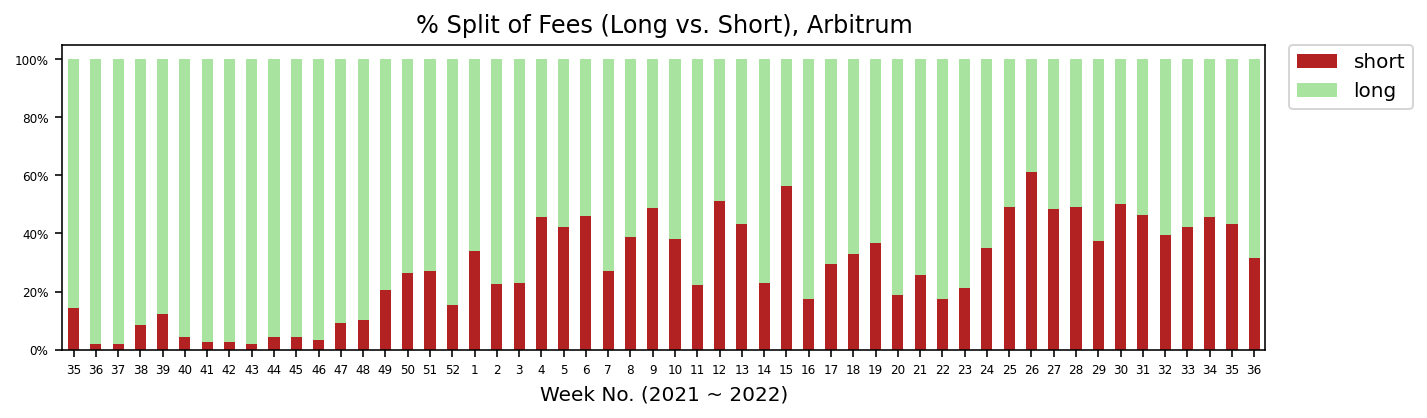

In [19]:
# title=tit+'\n'+subtit, ylabel='', xlabel='', 
ax = (da.loc[:, ['pct_short', 'pct_long']]
        .plot(kind='bar', stacked=True, rot=0, color=['#b22222', '#a8e4a0'], fontsize=6))
ax.set_xticklabels(da.index.get_level_values(1), fontsize=6)
ax.yaxis.set_major_formatter(PercentFormatter())
ax.set(xlabel='Week No. '+period)
plt.title("% Split of Fees (Long vs. Short), {}".format(chain)) 
plt.legend(['short', 'long'], bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.savefig(os.path.join(save_fig_dir, 'fees_long_vs_short.png'), dpi=300);